# 数据增广

大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。

In [2]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

from d2lzh import torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

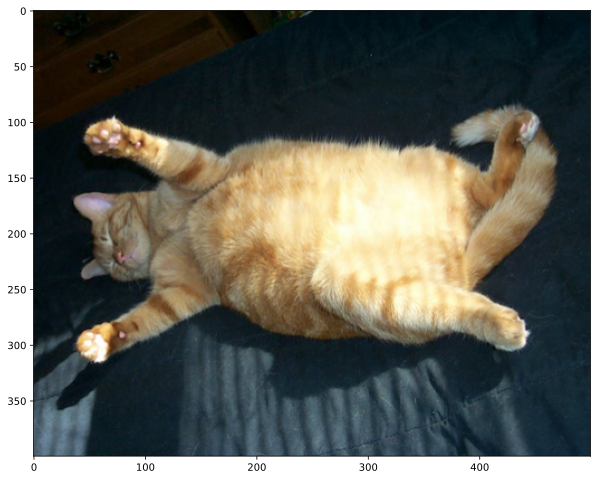

In [3]:
d2l.set_figsize(figsize=(10,10))
img = Image.open('img/cat1.jpg')
d2l.plt.imshow(img)

In [4]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

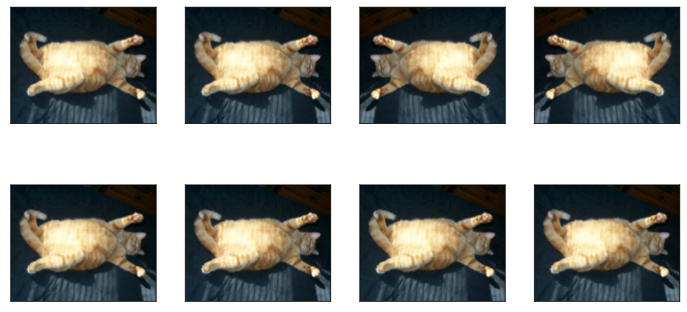

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

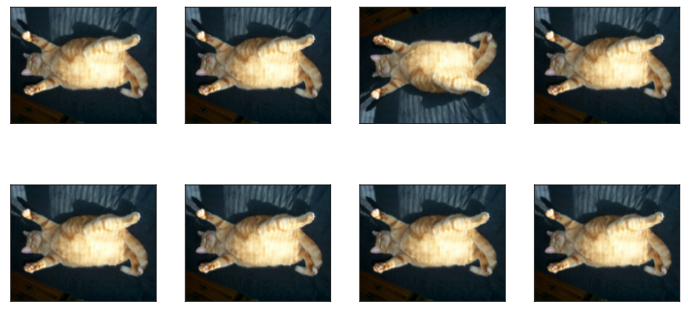

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

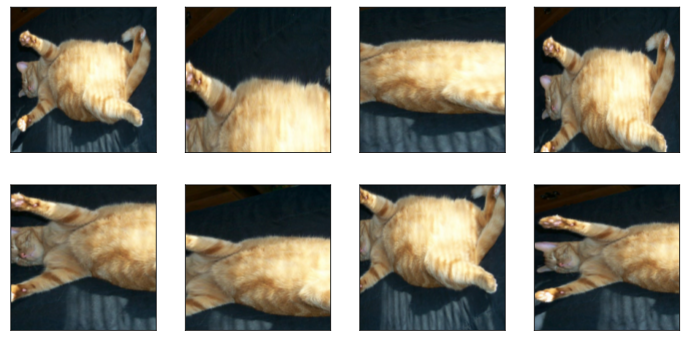

In [7]:
#对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

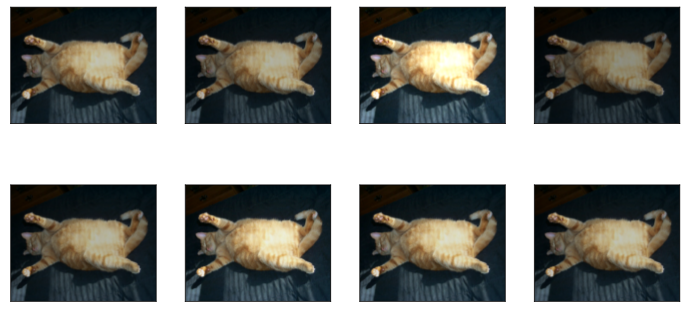

In [8]:
#变化亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue），使得模型对这些属性不敏感
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

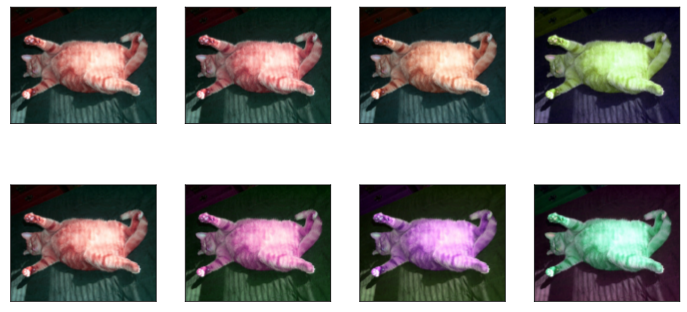

In [9]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

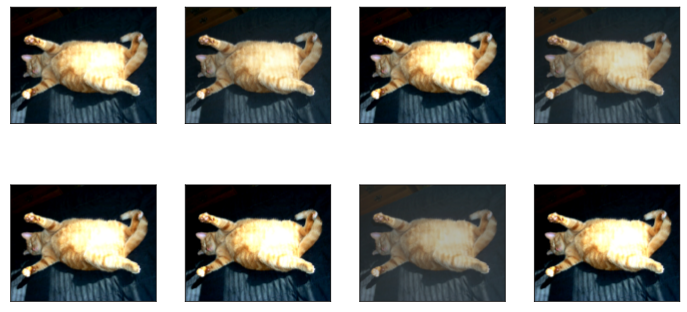

In [10]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

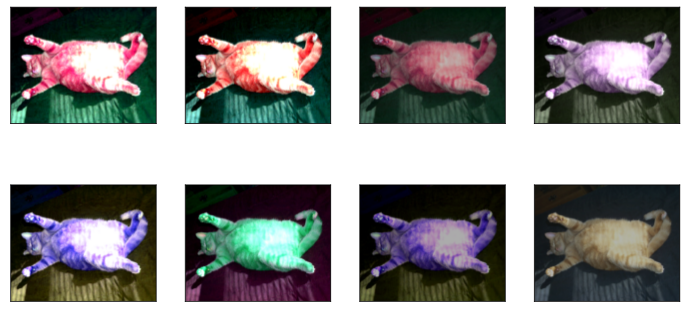

In [11]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

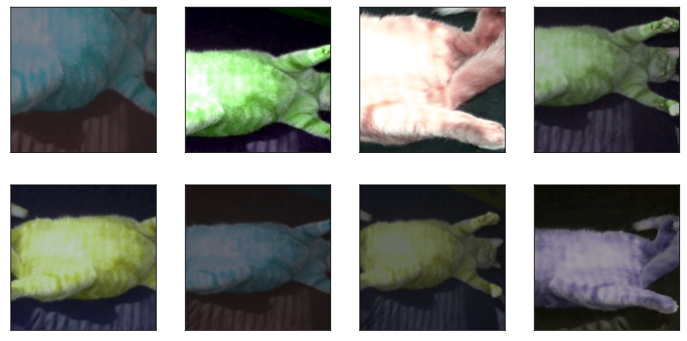

In [12]:
## 叠加多个数据增强方法
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 思考问题？从卷积的性质思考为何需要数据增广？

卷积不具备缩放不变性、旋转不变性

## 使用数据增广

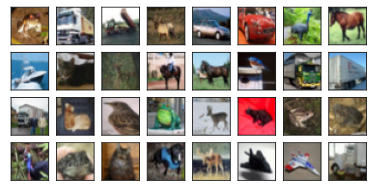

In [13]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="data/CIFAR/")
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

In [14]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [15]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="data/CIFAR/"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [16]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [17]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [18]:
#train without data aug
train_with_data_aug(no_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.4138, train acc 0.484, test acc 0.475, time 14.9 sec
epoch 2, loss 0.5025, train acc 0.644, test acc 0.596, time 14.9 sec
epoch 3, loss 0.2770, train acc 0.707, test acc 0.654, time 15.1 sec
epoch 4, loss 0.1784, train acc 0.750, test acc 0.621, time 15.1 sec
epoch 5, loss 0.1241, train acc 0.781, test acc 0.686, time 15.1 sec
epoch 6, loss 0.0896, train acc 0.812, test acc 0.710, time 15.1 sec
epoch 7, loss 0.0662, train acc 0.837, test acc 0.684, time 15.0 sec
epoch 8, loss 0.0493, train acc 0.863, test acc 0.657, time 15.0 sec
epoch 9, loss 0.0358, train acc 0.889, test acc 0.735, time 15.0 sec
epoch 10, loss 0.0280, train acc 0.903, test acc 0.706, time 15.0 sec


In [19]:
#train with data aug
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.3777, train acc 0.502, test acc 0.447, time 15.0 sec
epoch 2, loss 0.4940, train acc 0.650, test acc 0.625, time 15.1 sec
epoch 3, loss 0.2798, train acc 0.704, test acc 0.581, time 15.1 sec
epoch 4, loss 0.1859, train acc 0.741, test acc 0.652, time 15.0 sec
epoch 5, loss 0.1325, train acc 0.768, test acc 0.704, time 15.0 sec
epoch 6, loss 0.0998, train acc 0.790, test acc 0.679, time 15.0 sec
epoch 7, loss 0.0798, train acc 0.805, test acc 0.738, time 15.1 sec
epoch 8, loss 0.0637, train acc 0.823, test acc 0.617, time 15.1 sec
epoch 9, loss 0.0521, train acc 0.837, test acc 0.750, time 15.1 sec
epoch 10, loss 0.0431, train acc 0.852, test acc 0.744, time 15.1 sec
